In [1]:
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt

model = SentenceTransformer('all-mpnet-base-v2')

In [45]:
df_snli = pd.read_json("./snli_1.0/snli_1.0/snli_1.0_dev.jsonl", lines=True)
df_multnli = pd.read_json("./multinli_1.0/multinli_1.0/multinli_1.0_dev_matched.jsonl", lines=True)
df_snli.head()

,annotator_labels,captionID,gold_label,pairID,sentence1,sentence1_binary_parse,sentence1_parse,sentence2,sentence2_binary_parse,sentence2_parse
0,"[neutral, entailment, neutral, neutral, neutral]",4705552913.jpg#2,neutral,4705552913.jpg#2r1n,Two women are embracing while holding to go pa...,( ( Two women ) ( ( are ( embracing ( while ( ...,(ROOT (S (NP (CD Two) (NNS women)) (VP (VBP ar...,The sisters are hugging goodbye while holding ...,( ( The sisters ) ( ( are ( ( hugging goodbye ...,(ROOT (S (NP (DT The) (NNS sisters)) (VP (VBP ...
1,"[entailment, entailment, entailment, entailmen...",4705552913.jpg#2,entailment,4705552913.jpg#2r1e,Two women are embracing while holding to go pa...,( ( Two women ) ( ( are ( embracing ( while ( ...,(ROOT (S (NP (CD Two) (NNS women)) (VP (VBP ar...,Two woman are holding packages.,( ( Two woman ) ( ( are ( holding packages ) )...,(ROOT (S (NP (CD Two) (NN woman)) (VP (VBP are...
2,"[contradiction, contradiction, contradiction, ...",4705552913.jpg#2,contradiction,4705552913.jpg#2r1c,Two women are embracing while holding to go pa...,( ( Two women ) ( ( are ( embracing ( while ( ...,(ROOT (S (NP (CD Two) (NNS women)) (VP (VBP ar...,The men are fighting outside a deli.,( ( The men ) ( ( are ( fighting ( outside ( a...,(ROOT (S (NP (DT The) (NNS men)) (VP (VBP are)...
3,"[entailment, entailment, entailment, entailmen...",2407214681.jpg#0,entailment,2407214681.jpg#0r1e,"Two young children in blue jerseys, one with t...",( ( ( Two ( young children ) ) ( in ( ( ( ( ( ...,(ROOT (S (NP (NP (CD Two) (JJ young) (NNS chil...,Two kids in numbered jerseys wash their hands.,( ( ( Two kids ) ( in ( numbered jerseys ) ) )...,(ROOT (S (NP (NP (CD Two) (NNS kids)) (PP (IN ...
4,"[neutral, neutral, neutral, entailment, entail...",2407214681.jpg#0,neutral,2407214681.jpg#0r1n,"Two young children in blue jerseys, one with t...",( ( ( Two ( young children ) ) ( in ( ( ( ( ( ...,(ROOT (S (NP (NP (CD Two) (JJ young) (NNS chil...,Two kids at a ballgame wash their hands.,( ( ( Two kids ) ( at ( a ballgame ) ) ) ( ( w...,(ROOT (S (NP (NP (CD Two) (NNS kids)) (PP (IN ...


In [66]:

# Gets all relevant row data for model
def getRowData(index : int, df: pd.DataFrame):
    # Create sentence object
    sentObj = { "sentence1": None, "sentence2": None, "goldLabel": None, 'labels': None, 'embeddings1' : None, 'embeddings2': None, 'similarity': None}
    # retrieve apparent data
    sentObj["sentence1"] = df["sentence1"][index]
    sentObj["sentence2"] = df["sentence2"][index]
    sentObj["goldLabel"] = df["gold_label"][index]
    sentObj["labels"] = df["annotator_labels"][index]
    # Find embeddings
    sentObj["embeddings1"] = model.encode(sentObj["sentence1"])
    sentObj["embeddings2"] = model.encode(sentObj["sentence2"])
    # get Similarity
    sentObj['similarity'] = util.cos_sim(sentObj["embeddings1"], sentObj["embeddings2"])[0][0]
    return sentObj

vals = [getRowData(i, df_snli) for i in range(3000)]

In [67]:
import pywt
def denoize(arr):
    coeffs = pywt.wavedec(arr, 'db4', level=6)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(arr)))
    coeffs = [pywt.threshold(c, threshold, 'soft') for c in coeffs]
    return pywt.waverec(coeffs, 'db4')

def plotGraphs(vals):
    for val in vals:
        sentence1 = val["sentence1"]
        sentence2 = val["sentence2"]
        encodings1 = val["embeddings1"]
        encodings2 = val["embeddings2"]
        similarity = val["similarity"]
        labels = val["labels"]
        x = np.arange(len(encodings1))
        y = denoize(np.abs(encodings1 - encodings2))
        plt.plot(x[:180], y[:180])
        plt.show()
        print(f"Sentence 1: {sentence1}\nSentence 2: {sentence2}")
        print(f"Similarity: {similarity}")
        print(f"labels: {labels}")

# Going to see if there's points of inflection that is interesting
def findMinimumPoint(val, startIndex, endIndex):
    """
    Finds the minimum point in a sentence embedding between a range
    """
    embeddings1 = val['embeddings1']
    embeddings2 = val['embeddings2']
    y = denoize(np.abs(embeddings1 - embeddings2))
    min = 1
    minIndex = -1
    for i in range(startIndex, endIndex):
        if y[i] <= min:
            min = y[i]
            minIndex = i
    return minIndex


temp = [findMinimumPoint(val, 60, 120) for val in vals]

counts = {}

# loop over the elements in the list and update the counts dictionary
for elem in temp:
    if elem in counts:
        counts[elem] += 1
    else:
        counts[elem] = 1
counts = dict(sorted(counts.items()))
counts

{60: 767,
 61: 22,
 62: 29,
 63: 19,
 65: 27,
 66: 5,
 67: 3,
 69: 23,
 70: 40,
 71: 21,
 72: 31,
 73: 30,
 74: 22,
 75: 63,
 76: 72,
 77: 6,
 78: 10,
 79: 36,
 80: 11,
 81: 102,
 82: 117,
 83: 38,
 84: 18,
 85: 8,
 86: 20,
 87: 11,
 88: 1,
 89: 37,
 90: 13,
 92: 3,
 93: 48,
 94: 30,
 95: 7,
 96: 7,
 97: 25,
 98: 39,
 99: 52,
 100: 9,
 101: 32,
 102: 17,
 103: 4,
 104: 7,
 105: 12,
 106: 10,
 107: 19,
 108: 17,
 109: 4,
 110: 4,
 111: 3,
 112: 2,
 113: 23,
 114: 19,
 115: 8,
 116: 1,
 117: 14,
 118: 9,
 119: 973}

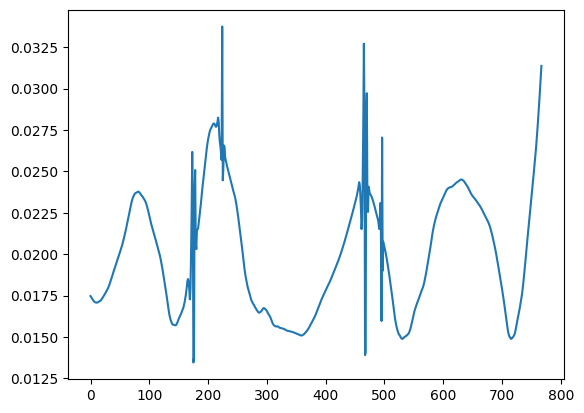

Sentence 1: A lady sitting on a bench that is against a building and under a poster of a man in a uniform waving.
Sentence 2: A person sitting
Similarity: 0.4751518964767456
labels: ['entailment', 'entailment', 'entailment', 'entailment', 'entailment']


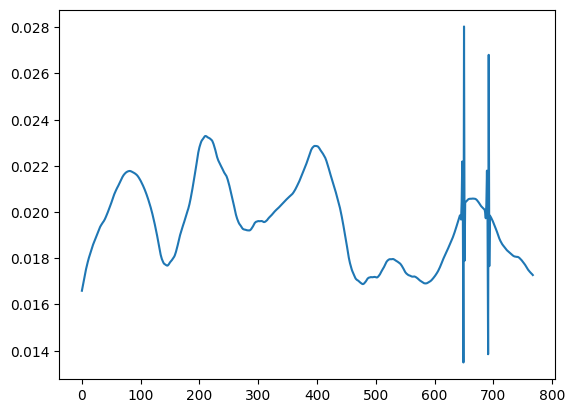

Sentence 1: A man wearing sunglasses is sitting on the steps outside, reading a magazine.
Sentence 2: The man is sitting.
Similarity: 0.43734046816825867
labels: ['entailment', 'entailment', 'entailment', 'entailment', 'entailment']


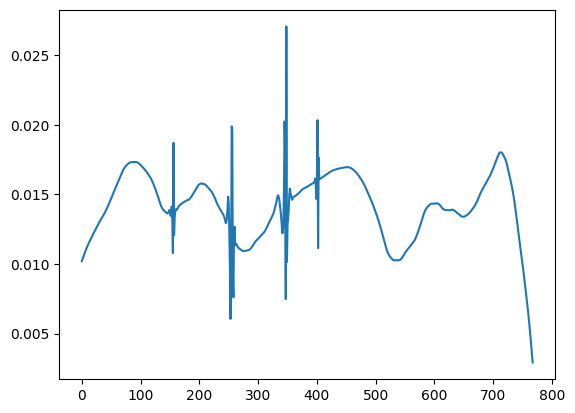

Sentence 1: A woman sitting outside weaving a long piece of red, white, and blue cloth.
Sentence 2: She is working with cloth
Similarity: 0.717677116394043
labels: ['entailment', 'entailment', 'entailment', 'entailment', 'entailment']


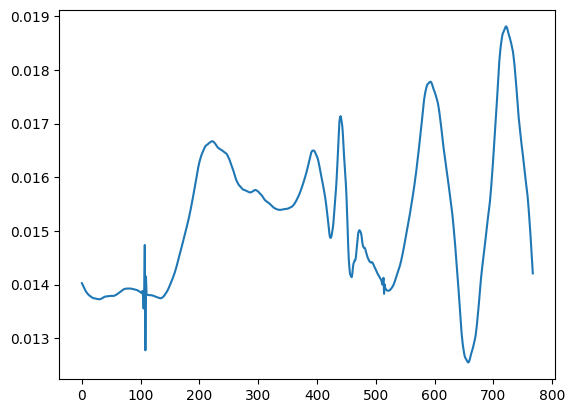

Sentence 1: A person rides his bicycle in the sand beside the ocean.
Sentence 2: A person is on a beach.
Similarity: 0.6857168674468994
labels: ['entailment', 'entailment', 'entailment', 'entailment', 'entailment']


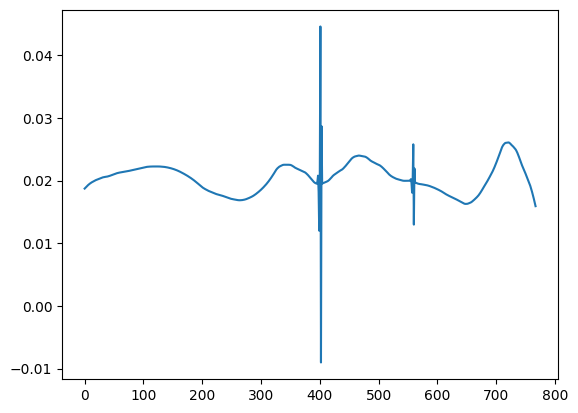

Sentence 1: A brown a dog and a black dog in the edge of the ocean with a wave under them boats are on the water in the background.
Sentence 2: The dogs are swimming among the boats.
Similarity: 0.3905761241912842
labels: ['entailment', 'entailment', 'entailment', 'entailment', 'entailment']


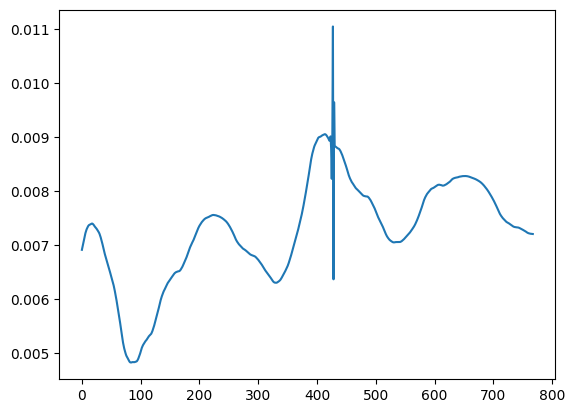

Sentence 1: Men stand on steps leading out of a body of water
Sentence 2: Men are standing on some steps near some water.
Similarity: 0.921667754650116
labels: ['entailment', 'entailment', 'entailment', 'entailment', 'entailment']


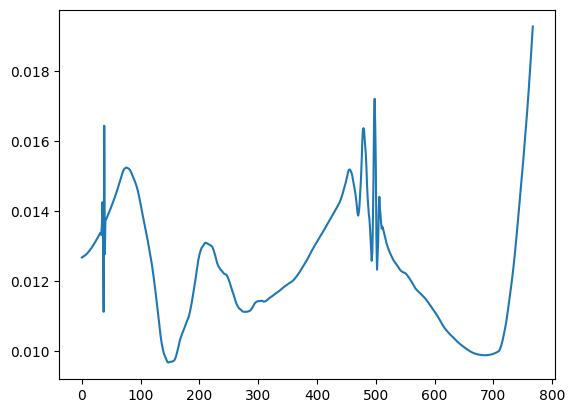

Sentence 1: A long-beaked bird in mid-flight.
Sentence 2: A bird flying.
Similarity: 0.7875219583511353
labels: ['entailment', 'entailment', 'entailment', 'entailment', 'entailment']


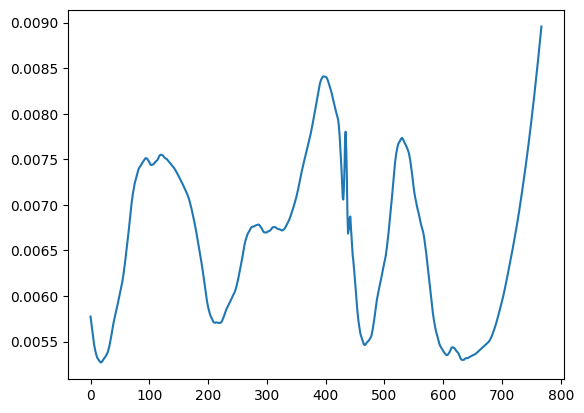

Sentence 1: A man in the middle east with a corn-on-the-cob cart selling corn.
Sentence 2: In the middle east, a man sells corn-on-the-cob from a cart.
Similarity: 0.9432958364486694
labels: ['entailment', 'entailment', 'entailment', 'entailment', 'entailment']


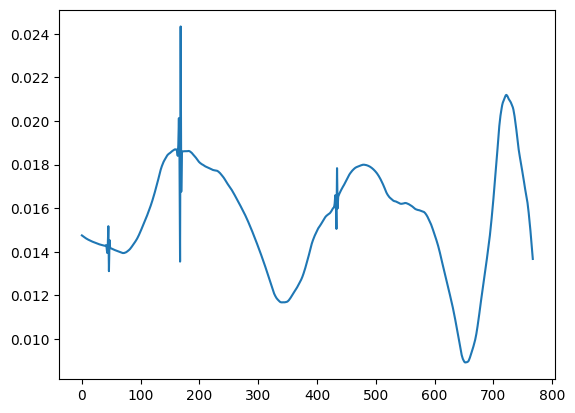

Sentence 1: Colorfully dressed people walk down the center of the road, with onlookers behind a barricade.
Sentence 2: A group of people walking down a road.
Similarity: 0.6492458581924438
labels: ['entailment', 'entailment', 'entailment', 'entailment', 'entailment']


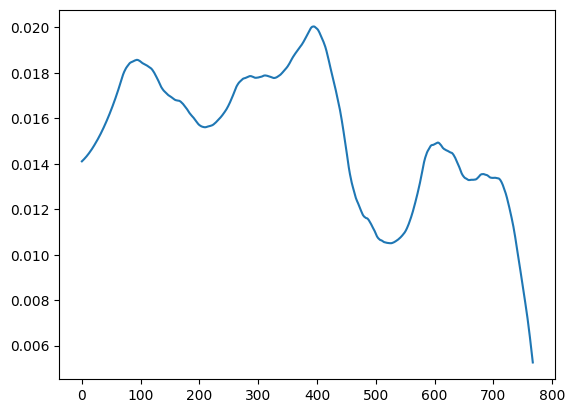

Sentence 1: A woman is talking on the phone while standing next to a dog.
Sentence 2: A woman is on the phone.
Similarity: 0.6809970140457153
labels: ['entailment', 'entailment', 'entailment', 'entailment', 'entailment']


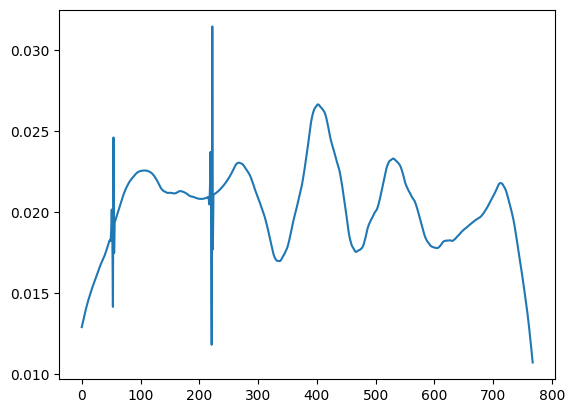

Sentence 1: Three young boys one is holding a camera and another is holding a green toy all are wearing t-shirt and smiling.
Sentence 2: The young boy has a camera.
Similarity: 0.4422948956489563
labels: ['entailment', 'entailment', 'entailment', 'entailment', 'entailment']


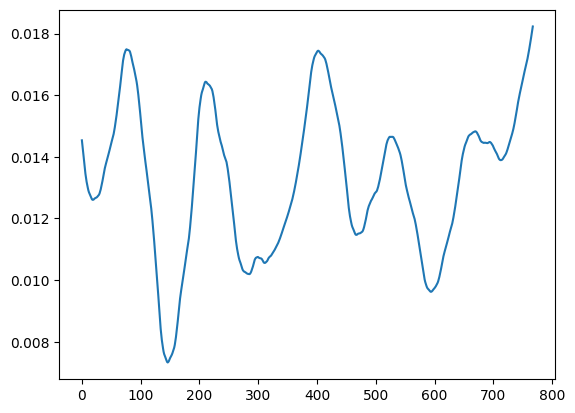

Sentence 1: 5 women sitting around a table doing some crafts.
Sentence 2: Five women sit at a table.
Similarity: 0.747270941734314
labels: ['entailment', 'entailment', 'entailment', 'entailment', 'entailment']


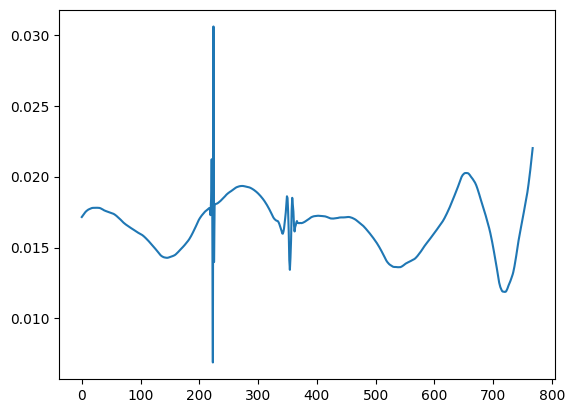

Sentence 1: Street performer with bowler hat and high boots performs outside.
Sentence 2: The person is performing.
Similarity: 0.620550274848938
labels: ['entailment', 'entailment', 'entailment', 'entailment', 'entailment']


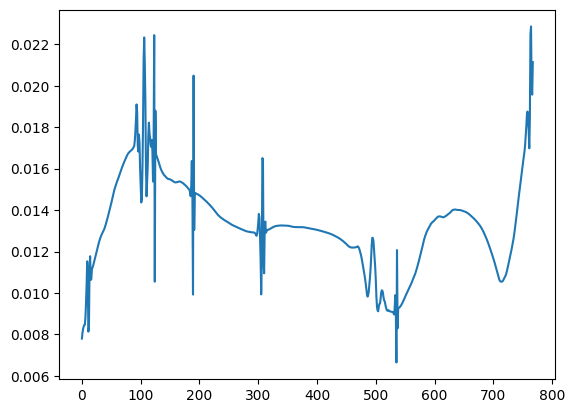

Sentence 1: A young boy playing in the grass.
Sentence 2: There is a child in the grass.
Similarity: 0.7672179937362671
labels: ['entailment', 'entailment', 'entailment', 'entailment', 'entailment']


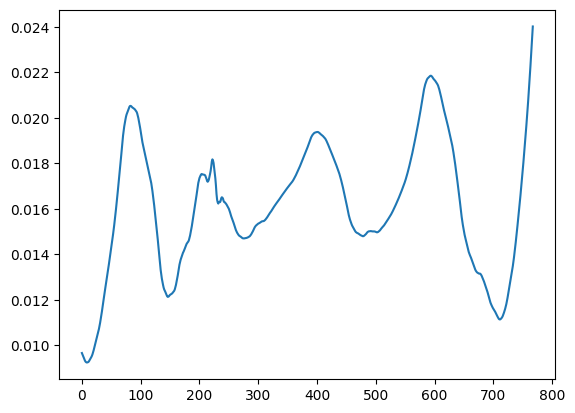

Sentence 1: Two men playing baseball with the one in the black and red jersey running toward base.
Sentence 2: There is a baseball game going on.
Similarity: 0.6320692300796509
labels: ['entailment', 'entailment', 'entailment', 'entailment', 'entailment']


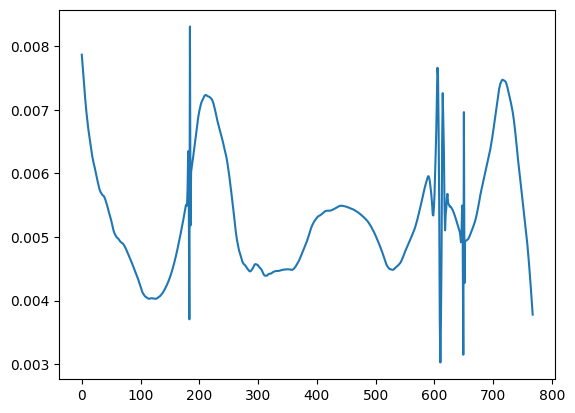

Sentence 1: A man and a woman are looking at produce on display.
Sentence 2: A man and woman are looking at produce.
Similarity: 0.954347550868988
labels: ['entailment', 'entailment', 'entailment', 'entailment', 'entailment']


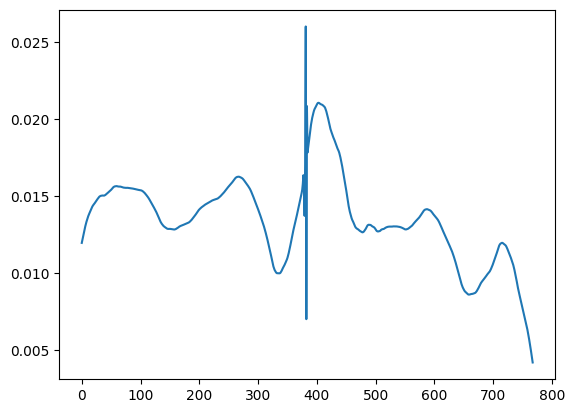

Sentence 1: People standing in line of a beer and curry line.
Sentence 2: People standing in line
Similarity: 0.7276245355606079
labels: ['entailment', 'entailment', 'entailment', 'entailment', 'entailment']


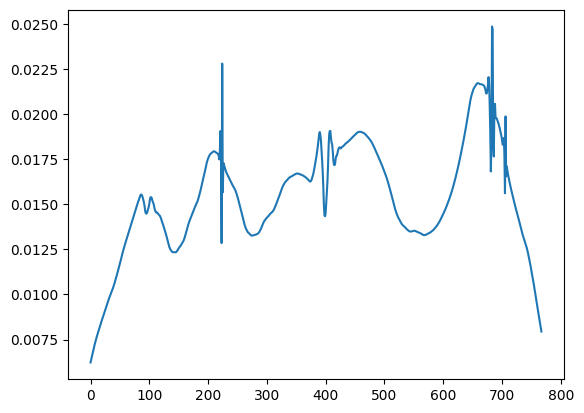

Sentence 1: A man and a woman are talking in a park
Sentence 2: A pair of people are talking outdoors.
Similarity: 0.6843776106834412
labels: ['entailment', 'entailment', 'entailment', 'entailment', 'entailment']


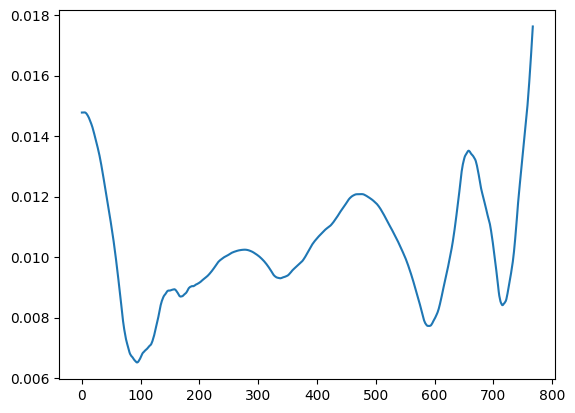

Sentence 1: A small ice cream stand with two people standing near it.
Sentence 2: Two people standing outside an ice cream stand.
Similarity: 0.8543531894683838
labels: ['entailment', 'entailment', 'entailment', 'entailment', 'entailment']


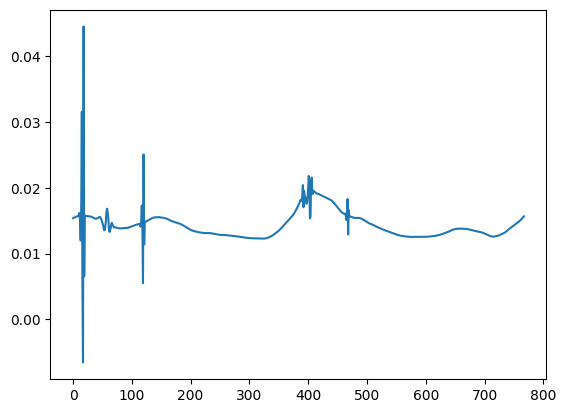

Sentence 1: A man wandering in the desert as the clouds roll in.
Sentence 2: A man wonders in the desert.
Similarity: 0.7136664390563965
labels: ['entailment', 'entailment', 'entailment', 'entailment', 'entailment']


In [42]:
def filter(text, label):
    allLabel = True
    for lab in text:
        if lab != label:
            allLabel = False
            break
    return 
    
entailment_list = ['entailment'] * 5
df = df_snli[df_snli['annotator_labels'].apply(lambda x: x == entailment_list)].reset_index(drop=True)
vals = [getRowData(i, df) for i in range(20, 40)]
plotGraphs(vals)

### Entailment findings
- Does changes in entailment effect shape of wave?

Could potentially split parameters into 5 seperate sub categories, train model to detect potential areas of 'entailment, contradiction and neutrality'
is this all the model detects? (Logical comparisons still accomplish the base task, may need to incorporate some form of classifier however) (To automate this I could potentially use a much larger model to train a smaller model)

The Entailment as Few-Shot Learner paper demonstrates that entailment can be used for sentiment classification by classifying a starting sentence and comparing how following sentences 'entail' it. These results have demonstrated comparable results to that of models of much greater size (in magnitudes of 100s). Should look into this more. I saved paper to my harddrive. Should back-up to NAS

Need to get better at saving my work. Remember to take photos of my notes for backup.